In [1]:
import os, sys

module_path = os.path.abspath('../..')
if module_path not in sys.path:
    sys.path.append(module_path)

import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from unisys import gate, circuit
from unisys.utils import operator, arch
from unisys.mapping import heuristic


## SABRE routing algorithm

### Overview demo

Overall, the SABRE routing algorithm will "pass" the circuit forward-and-backward for several periods and then perform a forward pass to search optimal SWAP gates to insert.

The default bidirectional pass period number `k=3`, meaning searching for 2k+1 passes in total

In [19]:
circ = circuit.Circuit([
    gate.H.on(0), gate.H.on(2), gate.H.on(5),
    gate.Z.on(0), gate.X.on(2, 1), gate.X.on(5, 4),
    gate.X.on(1, 0), gate.X.on(3, 2),
    gate.H.on(2), gate.H.on(3),
    gate.X.on(2, 1), gate.X.on(5, 3),
    gate.Z.on(3),
    gate.X.on(3, 4),
    gate.X.on(0, 3)
])

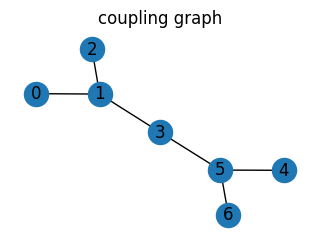

In [20]:
device = arch.read_device_topology('../../benchmark/topology/oslo.graphml')
plt.figure(figsize=(3, 2))
nx.draw(device, with_labels=True)
plt.title('coupling graph')
plt.show()

In [37]:
mapped_circ, init_mapping, final_mapping = heuristic.sabre_search(circ, device)

──────────────────────────────────────── SABRE bidirectional pass period 0 ────────────────────────────────────────

forward pass

dag nodes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
--------------------------------------------------
logical_qubits: [0, 1, 2, 3, 4, 5]
physical_qubits: [0, 1, 2, 3, 4, 5, 6]
initial_mapping: {0: 3, 1: 1, 2: 2, 3: 0, 4: 5, 5: 4}
final_mapping: {0: 1, 1: 2, 2: 0, 3: 3, 4: 5, 5: 4}


reversed pass

dag nodes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
initial_mapping: {0: 1, 1: 2, 2: 0, 3: 3, 4: 5, 5: 4}
final_mapping: {0: 2, 1: 1, 2: 0, 3: 3, 4: 5, 5: 4}


──────────────────────────────────────── SABRE bidirectional pass period 1 ────────────────────────────────────────

forward pass

dag nodes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
initial_mapping: {0: 2, 1: 1, 2: 0, 3: 3, 4: 5, 5: 4}
final_mapping: {0: 3, 1: 0, 2: 2, 3: 5, 4: 1, 5: 4}


reversed pass

dag nodes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]
initial_mapping: {0: 3, 1: 0, 2: 2, 3: 5, 4: 1, 5: 4}
final_mapping: {0: 3, 1: 1, 2: 2, 3: 0, 4: 5, 5: 4}


──────────────────────────────────────── SABRE bidirectional pass period 2 ────────────────────────────────────────

forward pass

dag nodes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
initial_mapping: {0: 3, 1: 1, 2: 2, 3: 0, 4: 5, 5: 4}
final_mapping: {0: 1, 1: 2, 2: 0, 3: 3, 4: 5, 5: 4}


reversed pass

dag nodes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
initial_mapping: {0: 1, 1: 2, 2: 0, 3: 3, 4: 5, 5: 4}
final_mapping: {0: 2, 1: 1, 2: 0, 3: 3, 4: 5, 5: 4}
dag nodes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
initial_mapping: {0: 2, 1: 1, 2: 0, 3: 3, 4: 5, 5: 4}
final_mapping: {0: 3, 1: 0, 2: 2, 3: 5, 4: 1, 5: 4}


In [44]:
# original circuit
print('original circuit:', circ)
circ.to_cirq()

original circuit: Circuit(num_gates: 15, num_qubits: 6, with_measure: False)


q_0: ───H───Z───@───────────────────X───
                │                   │
q_1: ───────@───X───────@───────────┼───
            │           │           │
q_2: ───H───X───@───H───X───────────┼───
                │                   │
q_3: ───────────X───H───@───Z───X───@───
                        │       │
q_4: ───────@───────────┼───────@───────
            │           │
q_5: ───H───X───────────X───────────────

In [45]:
# mapped circuit
print('mapped circuit:', mapped_circ)
print('init_mapping:', init_mapping)
print('final_mapping:', final_mapping)
mapped_circ.to_cirq()

mapped circuit: Circuit(num_gates: 27, num_qubits: 6, with_measure: False)
init_mapping: {0: 2, 1: 1, 2: 0, 3: 3, 4: 5, 5: 4}
final_mapping: {0: 3, 1: 0, 2: 2, 3: 5, 4: 1, 5: 4}


q_0: ───H───Z───@───────────────────────────X───@───X───────────────────────────
                │                           │   │   │
q_1: ───────@───X───@───X───@───@───H───X───@───X───@───────────X───@───X───────
            │       │   │   │   │       │                       │   │   │
q_2: ───H───X───────X───@───X───┼───────@───────────────────────┼───┼───┼───────
                                │                               │   │   │
q_3: ───────────────────────────X───H───X───@───X───────────@───@───X───@───X───
                                        │   │   │           │               │
q_4: ───────@───────────────────────────@───X───@───@───Z───X───────────────@───
            │                                       │
q_5: ───H───X───────────────────────────────────────X───────────────────────────

In [46]:
# verify the mapped circuit
arch.verify_mapped_circuit(circ, mapped_circ, init_mapping, final_mapping)

True

### Detailed demo

Herein we can see the detailed process of the one pass of SABRE routing algorithm.

In [4]:
circ_with_swaps, mappings = heuristic.sabre_search_one_pass(circ, device, return_circ_with_swaps=True, gene_init_mapping_type='trivial')

dag nodes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
--------------------------------------------------
logical_qubits: [0, 1, 2, 3, 4, 5]
physical_qubits: [0, 1, 2, 3, 4, 5, 6]
initial_mapping: {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5}
final_mapping: {0: 1, 1: 2, 2: 0, 3: 3, 4: 5, 5: 4}


In [5]:
# original circuit
circ.to_qiskit().draw()

┌───┐┌───┐                         ┌───┐
q_0: ┤ H ├┤ Z ├──■──────────────────────┤ X ├
     └───┘└───┘┌─┴─┐                    └─┬─┘
q_1: ───────■──┤ X ├───────■──────────────┼──
     ┌───┐┌─┴─┐└───┘┌───┐┌─┴─┐            │  
q_2: ┤ H ├┤ X ├──■──┤ H ├┤ X ├────────────┼──
     └───┘└───┘┌─┴─┐├───┤└───┘┌───┐┌───┐  │  
q_3: ──────────┤ X ├┤ H ├──■──┤ Z ├┤ X ├──■──
               └───┘└───┘  │  └───┘└─┬─┘     
q_4: ───────■──────────────┼─────────■───────
     ┌───┐┌─┴─┐          ┌─┴─┐               
q_5: ┤ H ├┤ X ├──────────┤ X ├───────────────
     └───┘└───┘          └───┘

In [6]:
# circuit with inserted swaps
circ_with_swaps.to_qiskit().draw()

┌───┐┌───┐                                 ┌───┐
q_0: ┤ H ├┤ Z ├──■──────────────────────X───────┤ X ├
     └───┘└───┘┌─┴─┐                    │       └─┬─┘
q_1: ───────■──┤ X ├─X─────────────■────┼─────────┼──
     ┌───┐┌─┴─┐└───┘ │      ┌───┐┌─┴─┐  │         │  
q_2: ┤ H ├┤ X ├──────X───■──┤ H ├┤ X ├──X─────────┼──
     └───┘└───┘        ┌─┴─┐├───┤└───┘┌───┐┌───┐  │  
q_3: ──────────────────┤ X ├┤ H ├──■──┤ Z ├┤ X ├──■──
                       └───┘└───┘  │  └───┘└─┬─┘     
q_4: ───────■──────────────────────┼────X────■───────
     ┌───┐┌─┴─┐                  ┌─┴─┐  │            
q_5: ┤ H ├┤ X ├──────────────────┤ X ├──X────────────
     └───┘└───┘                  └───┘

As we can see, there are 3 SWAP gates inserted, so the result maintains 4 intermediate mappings (the first one is the initial mapping; the last one is the final mapping). 

We can unify such a circuit to generate a circuit with only the initial and final mappings, i.e., all the inner intermediate mappings hold the same, which will be more convenient for execution analysis and execution on hardware.

In [8]:
mappings

[{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5},
 {0: 0, 1: 2, 2: 1, 3: 3, 4: 4, 5: 5},
 {0: 0, 1: 2, 2: 1, 3: 3, 4: 5, 5: 4},
 {0: 1, 1: 2, 2: 0, 3: 3, 4: 5, 5: 4}]

In [13]:
# mapped circuit with only init_mapping and final_mapping
init_mapping, final_mapping = mappings[0], mappings[-1]
mapped_circ = arch.unify_mapped_circuit(circ_with_swaps, mappings)
mapped_circ.to_qiskit().draw()

┌───┐┌───┐                                   ┌───┐     ┌───┐          
q_0: ┤ H ├┤ Z ├──■────────────────────────────────┤ X ├──■──┤ X ├──────────
     └───┘└───┘┌─┴─┐     ┌───┐          ┌───┐┌───┐└─┬─┘┌─┴─┐└─┬─┘     ┌───┐
q_1: ───────■──┤ X ├──■──┤ X ├──■────■──┤ H ├┤ X ├──■──┤ X ├──■───────┤ X ├
     ┌───┐┌─┴─┐└───┘┌─┴─┐└─┬─┘┌─┴─┐  │  └───┘└─┬─┘     └───┘          └─┬─┘
q_2: ┤ H ├┤ X ├─────┤ X ├──■──┤ X ├──┼─────────■────────────────────────┼──
     └───┘└───┘     └───┘     └───┘┌─┴─┐┌───┐     ┌───┐          ┌───┐  │  
q_3: ──────────────────────────────┤ X ├┤ H ├──■──┤ Z ├──────────┤ X ├──■──
                                   └───┘└───┘  │  ├───┤     ┌───┐└─┬─┘     
q_4: ───────■──────────────────────────────────┼──┤ X ├──■──┤ X ├──┼───────
     ┌───┐┌─┴─┐                              ┌─┴─┐└─┬─┘┌─┴─┐└─┬─┘  │       
q_5: ┤ H ├┤ X ├──────────────────────────────┤ X ├──■──┤ X ├──■────■───────
     └───┘└───┘                              └───┘     └───┘

Then let us see whether the `mapped_circ` is unitary equivalent to the original circuit `circ`.

In [12]:
arch.verify_mapped_circuit(circ, mapped_circ, init_mapping, final_mapping)

True